In [1]:
import os
import json
from typing import Dict, List, Optional, Union, cast
import requests
import re
import unicodedata
import pandas as pd

from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
import seaborn as sns
import json
# import acquire
import prepare
import dev_wrangle as w

from env import github_token, github_username
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
df = pd.read_json('data2.json')

In [3]:
df.shape

(250, 3)

In [4]:
df.head()

,repo,language,readme_contents
0,bitcoin/bitcoin,C++,Bitcoin Core integration/staging tree\n=======...
1,bitcoinbook/bitcoinbook,AsciiDoc,Code Examples: ![travis_ci](https://travis-ci....
2,bitcoinj/bitcoinj,Java,image:https://github.com/bitcoinj/bitcoinj/wor...
3,bitcoin/bips,Wikitext,"People wishing to submit BIPs, first should pr..."
4,bitcoinjs/bitcoinjs-lib,TypeScript,# BitcoinJS (bitcoinjs-lib)\n[![Github CI](htt...


In [5]:
df = w.prepare_df(df)

In [6]:
df

,repo,language,readme_contents,readme_contents_clean,length,unique
0,bitcoin/bitcoin,C++,Bitcoin Core integration/staging tree\n=======...,bitcoin core integration staging tree http bit...,3364,27
1,bitcoinj/bitcoinj,Java,image:https://github.com/bitcoinj/bitcoinj/wor...,image http github com bitcoinj bitcoinj workfl...,4642,35
2,spesmilo/electrum,Python,# Electrum - Lightweight Bitcoin client\n\n```...,electrum lightweight bitcoin client licence mi...,4270,36
3,bitcoin-wallet/bitcoin-wallet,Java,# BITCOIN WALLET\n\nWelcome to _Bitcoin Wallet...,bitcoin wallet welcome _bitcoin wallet_ standa...,1317,33
4,etotheipi/BitcoinArmory,C++,##Armory\n\n**Created by Alan Reiner on 13 Jul...,armory created alan reiner 13 july 2011 armory...,4101,38
...,...,...,...,...,...,...
122,graymauser/btcposbal2csv,Python,## Dump Bitcoin addresses with positive balanc...,dump bitcoin address positive balance simple u...,2974,37
123,square/subzero,Java,[![Build Status](https://github.com/square/sub...,build status http github com square subzero ac...,3053,31
124,gazbert/bxbot,Java,# BX-bot\n\n[![Gradle CI](https://github.com/g...,bx bot gradle ci http github com gazbert bxbot...,35813,38
125,DeFiCh/ain,C++,[![Lint](https://github.com/DeFiCh/ain/actions...,lint http github com defich action workflow li...,2882,36


In [7]:
df.language.value_counts()

Python        49
JavaScript    37
C++           21
Java          20
Name: language, dtype: int64

In [8]:
train, val, test = w.train_val_test(df, target=None, stratify=None, seed=42)
train.shape, val.shape, test.shape

((76, 6), (25, 6), (26, 6))

In [9]:
X_train, y_train, X_val, y_val, X_test, y_test = w.x_y_split(df, 'language')

In [10]:
X_train_tfid, X_val_tfid, X_test_tfid= w.get_tfid(X_train, X_val, X_test, y_train, y_val, y_test)

In [11]:
words = w.clean_text(' '.join(train['readme_contents_clean']))

In [12]:
#### 1. What are the most common words in READMEs?

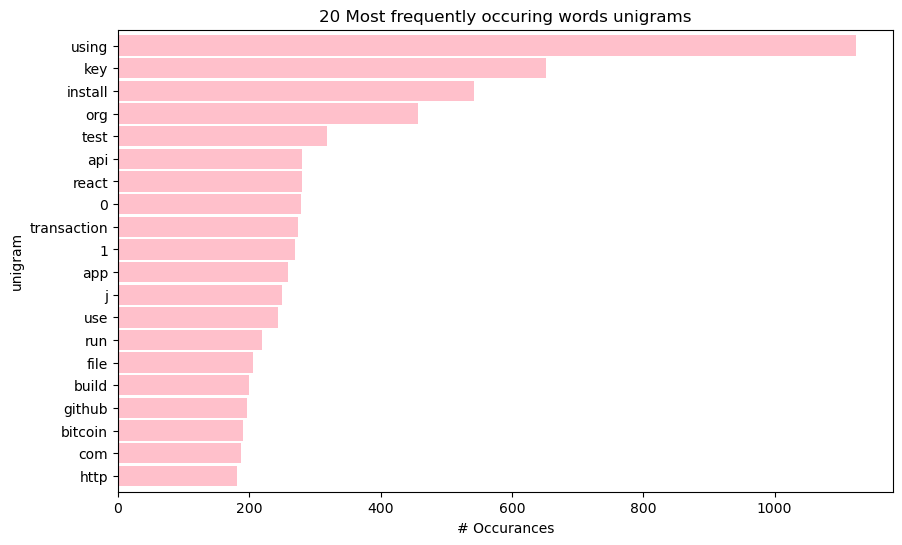

In [13]:
w.viz_most_common_unigrams(words)

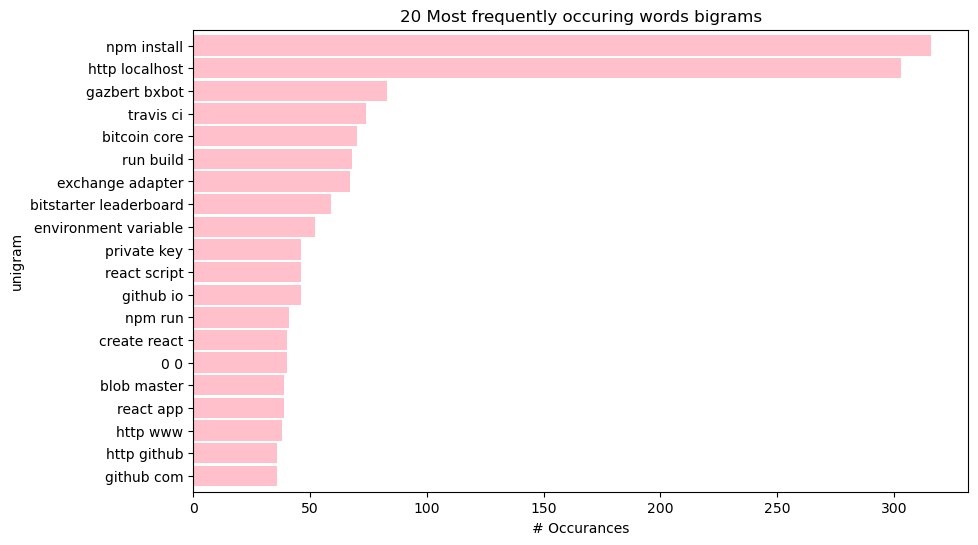

In [14]:
w.viz_most_common_bigrams(words)

In [15]:
#### 2. Does the length of the README vary by programming language?

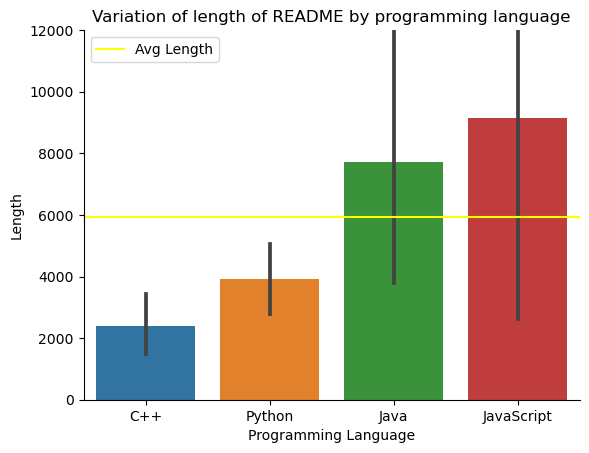

In [16]:
w.viz_length_content(train)

In [17]:
#### 3. Do different programming languages use a different number of unique words?

In [18]:
df.groupby('language').unique.value_counts()

language    unique
C++         27         5
            38         5
            36         3
            33         2
            37         2
            7          1
            20         1
            29         1
            34         1
Java        38         8
            35         3
            37         3
            31         2
            36         2
            29         1
            33         1
JavaScript  38        10
            37         7
            32         5
            22         4
            29         2
            33         2
            35         2
            9          1
            18         1
            30         1
            34         1
            36         1
Python      38        13
            35         7
            37         7
            36         5
            33         4
            27         3
            34         3
            31         2
            0          1
            20         1
            23         1
      

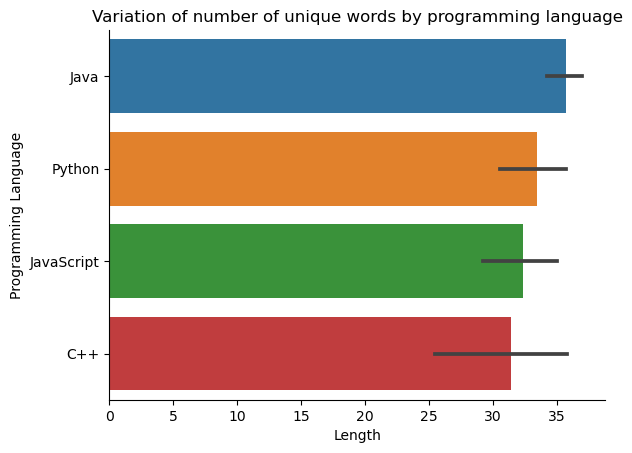

In [19]:
w.viz_count_unique(train)

In [20]:
# Modeling

In [21]:
w.get_baseline_accuracy(y_train)

Baseline accuracy: 0.39473684210526316


In [22]:
df_1 = w.decision_tree(X_train_tfid, X_val_tfid, y_train, y_val)

In [23]:
df_1.sort_values(by=['validate_accuracy', 'difference'], ascending = [False,True]).head(10)

,max_depth,train_accuracy,validate_accuracy,difference
3,4,0.763158,0.76,0.003158
2,3,0.710526,0.68,0.030526
4,5,0.828947,0.68,0.148947
8,9,0.986842,0.68,0.306842
5,6,0.907895,0.64,0.267895
6,7,0.947368,0.64,0.307368
7,8,0.973684,0.64,0.333684
1,2,0.697368,0.60,0.097368
0,1,0.552632,0.56,-0.007368


In [24]:
df_2 = w.random_forest_tree(X_train_tfid, X_val_tfid, y_train, y_val)

In [25]:
df_2.sort_values(by=['validate_accuracy', 'difference'], ascending = [False,True]).head(10)

,min_samples_leaf,train_accuracy,validate_accuracy,difference
0,1,1.000000,0.68,0.320000
2,3,0.934211,0.64,0.294211
1,2,0.973684,0.64,0.333684
4,5,0.736842,0.60,0.136842
3,4,0.815789,0.60,0.215789
6,7,0.631579,0.56,0.071579
9,10,0.473684,0.52,-0.046316
8,9,0.539474,0.52,0.019474
7,8,0.605263,0.52,0.085263
5,6,0.684211,0.52,0.164211


In [26]:
def logistic_regression_test(X_trains, X_validates, y_train, y_validate):
    # using Logistic regression model with different values of hyperparameter c to find best model

    # create an empty list to append output
    metrics = []
    
    
    solver_list=['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

    # create model1 of logistic regression
#     logit1 = LogisticRegression(C = 1, random_state=42, solver='liblinear')
#     logit2 = LogisticRegression(C = 0.1, random_state=42, solver='liblinear')
    for solver in solver_list:
        
        # fit model
        logit = LogisticRegression(C=1, random_state=42,
                           intercept_scaling=1, solver=solver)
        
        # fit the model to training data
        logit.fit(X_trains, y_train)

        # accuracy score on train
        accuracy_train = logit.score(X_trains,y_train)

        # accuracy score on validate
        accuracy_validate =logit.score(X_validates,y_validate)

        output = {'solver': solver,
                 'train_accuracy': accuracy_train,
                 'validate_accuracy': accuracy_validate,
                 }
        metrics.append(output)
    
    df = pd.DataFrame(metrics)
    
    df['difference'] = df.train_accuracy - df.validate_accuracy
    
    return df

In [27]:
def logistic_regression_test_1(X_trains, X_validates, y_train, y_validate):
    # using Logistic regression model with different values of hyperparameter c to find best model

    # create an empty list to append output
    metrics = []
    
    
    solver_list=['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    c_values = [100, 10, 1.0, 0.1, 0.01]

    # create model1 of logistic regression
#     logit1 = LogisticRegression(C = 1, random_state=42, solver='liblinear')
#     logit2 = LogisticRegression(C = 0.1, random_state=42, solver='liblinear')
    lr_2_train_scores = []
    lr_2_validate_scores = []
    solver_list_names=[]
    c_value_list=[]
    for i in solver_list:
        for j in c_values:
            logit_loop_2 = LogisticRegression(C=j, random_state=42,
                                   intercept_scaling=1, solver=i)
            logit_loop_2.fit(X_trains, y_train)
            lr_2_train_scores.append(logit_loop_2.score(X_trains, y_train))
            lr_2_validate_scores.append(logit_loop_2.score(X_validates, y_validate))
            solver_list_names.append(i)
            c_value_list.append(j)
    lr_2_scores = {'train':lr_2_train_scores,'validate':lr_2_validate_scores,'solver_list':solver_list_names,'c_values':c_value_list}


    df = pd.DataFrame(lr_2_scores)
    
    df['difference'] = df.train - df.validate
    
    return df

In [28]:
df_3 = w.knn(X_train_tfid, X_val_tfid, y_train, y_val)

In [29]:
df_3.sort_values(by=['validate_accuracy', 'difference'], ascending = [False,True]).head(10)

,n_neighbors,train_accuracy,validate_accuracy,difference
5,6,0.657895,0.76,-0.102105
4,5,0.723684,0.76,-0.036316
10,11,0.578947,0.72,-0.141053
8,9,0.592105,0.72,-0.127895
9,10,0.592105,0.72,-0.127895
6,7,0.631579,0.72,-0.088421
3,4,0.736842,0.72,0.016842
7,8,0.631579,0.68,-0.048421
1,2,0.973684,0.68,0.293684
12,13,0.539474,0.64,-0.100526


In [ ]:
models_df = w.get_models_accuracy(X_train_tfid, X_val_tfid, y_train, y_val)
models_df 

In [ ]:
w.viz_models_accuracy(models_df)


In [ ]:
# Model Evalution

In [ ]:
w.get_decison_tree_test(X_train_tfid, X_test_tfid, y_train, y_test,4)